# **Project 3 - Explainable AI with SHAP**


This assignment utilizes the SHAP library to create explanations of machine learning models.

Make sure to use https://shap.readthedocs.io/en/latest/ throughout the assignment, e.g., for API reference and examples.

Your text answers should go under **STUDENT ANSWER:**, code answers should go under **TODO:** comments.

Good luck!

### Task 1: Warm up - Explainable AI

* 1.1 Why are XAI methods like SHAP useful? Briefly explain 3 different use cases of XAI.



**STUDENT ANSWER:**

XAI is used to explain your model in simpler terms. This can be done in many different ways, and SHAP is one of these. SHAP is Shapley Additive exPlanations, and is inspired by shapley values from game theory. It is used to describe each parameters contribution to the predictions. You can also use a surrogate model to explain your models with a simpler one you actually understand. This is done locally around some value of X. A third use case is to explain the concepts your model is picking up on, like "stripes". This is not explicitly programmed into your model, but you can use weights from different layers (from neural nets) to get an idea of how the concept is represented in the model.

## **Mission Part 1**: 🎯 Target SkyNet’s most valuable base

### **[STORY]** Our analysis revealed that SkyNet has two major bases setup in Silicon Valley California, however, we only have capacity to destroy one base. It is crucial that you find which base that is of most value to SkyNet. Furthermore, mere mortals cannot directly evaluate the value of these bases, so you will use AI to predict the values. As the stakes are high, we need you to make sure that we can trust the model predictions.

### **[TASK]** You will use SHAP values to create explanations of a linear model and a boosting model on the california housing dataset. The code for the models are provided.

In [4]:
# It is recommended to use this version of SHAP:
!pip install shap==0.46.0


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Imports

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
import torch
from sklearn.datasets import fetch_openml
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, r2_score
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

### Data preparation

In [16]:
# Lets prepare the data: have a look at the outputs.
data, target = shap.datasets.california()
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

# We have 8 features and a single target value (the value of the house).
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")
X_train.head()

X_train shape: (16512, 8)
y_train shape: (16512,)
X_test shape: (4128, 8)
y_test shape: (4128,)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
14196,3.2596,33.0,5.017657,1.006421,2300.0,3.691814,32.71,-117.03
8267,3.8125,49.0,4.473545,1.041005,1314.0,1.738095,33.77,-118.16
17445,4.1563,4.0,5.645833,0.985119,915.0,2.723214,34.66,-120.48
14265,1.9425,36.0,4.002817,1.033803,1418.0,3.994366,32.69,-117.11
2271,3.5542,43.0,6.268421,1.134211,874.0,2.300000,36.78,-119.80


### The linear model


R2 Score: 0.576


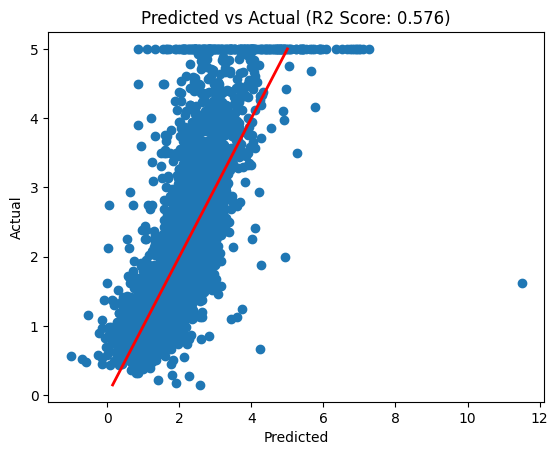

In [8]:
# Train a linear model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Plot predicted vs actual values
score = r2_score(y_test, linear_model.predict(X_test))
print(f"R2 Score: {score:.3f}")
plt.title(f"Predicted vs Actual (R2 Score: {score:.3f})")
plt.scatter(linear_model.predict(X_test), y_test)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Coefficients

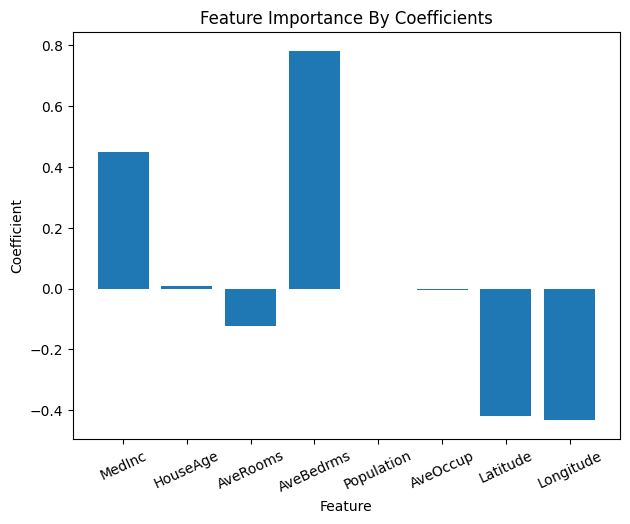

In [17]:
# Plot the coefficients of the linear model with feature names
# For linear models, the coefficients is an easy way to interpret feature importance
plt.bar(data.columns, linear_model.coef_)
plt.xlabel("Feature")
plt.ylabel("Coefficient")
plt.tight_layout()
plt.title("Feature Importance By Coefficients")
plt.xticks(rotation=25)
plt.show()

### SHAP feature importance

ExactExplainer explainer: 4129it [00:12, 79.05it/s]                           

SHAP values shape: (4128, 8)


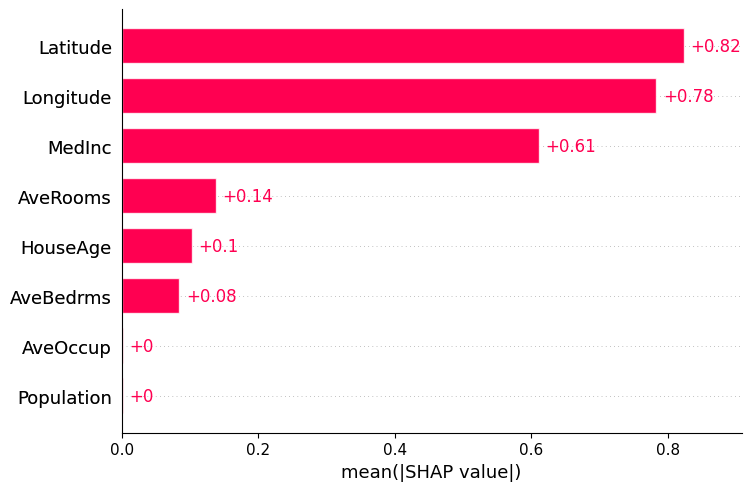

In [18]:
# Now we use SHAP for feature importance
# We use the training dataset as background data for SHAP
explainer = shap.Explainer(linear_model.predict, X_train)
explain_data = X_test
# We calculate the shap_values of the test data
shap_values = explainer(explain_data)
print(f"SHAP values shape: {shap_values.shape}")
shap.plots.bar(shap_values)

### Task 2: Coefficients vs SHAP values

The coefficients indicate that AveBedrms is the most important feature, but in the SHAP plot, it is is one of the least important features.

* 2.1 Explain why this is the case.

(hint: It has to do with feature distributions. data.hist and data.describe might be useful)

**STUDENT ANSWER:**

2.1

The plots / metrics below are used to answer this.

There is a significant difference in how coefficient and SHAP values work / are used to describe feature importance. The coefficient doesn't say much about how important the feature is to actually describe the data, just to mimic it. For the AveBedrms, there are a lot of points in the start of the distribution and very few at the end. This is seen in the describe below, where 75% of the data has AveBedrms <= 1.099, which is very close to the mean value of 1.096. The distribution of the target is also heavily focused around one value, approximately 1.7. For the target, 75% of the data is <= 2.65. Since the values/distribution are comparable and quite dense, this is used for predictions in a linear regressor. It doens't describe the data much, but instead fits a line to suit the targets. This can of course describe the data well, but not always. XAI methods like SHAP show how changes in values of feature affect the predictions, and are therefore better to describe the data. The SHAP plot shows that AveBedrms doesn't actually contribute all that much to describing the data.

In [57]:
data.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000


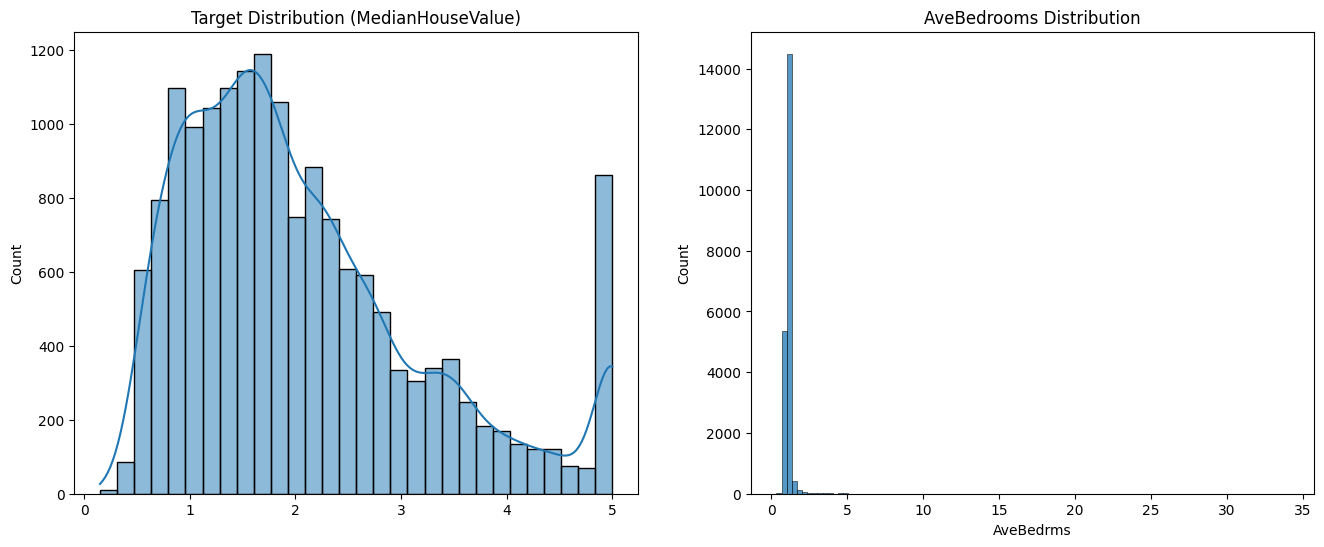

In [58]:
# %pip install seaborn
import seaborn as sns

# descrobe distribution of target (numpy array)
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.title("Target Distribution (MedianHouseValue)")
sns.histplot(y_train, bins=30, kde=True)
plt.subplot(1, 2, 2)
plt.title("AveBedrooms Distribution")
sns.histplot(data['AveBedrms'], bins=100)
plt.show()

In [62]:
target_cp = target.copy()
target_cp = np.sort(target_cp)
print("75% target:", target_cp[int(0.75*len(target_cp))])

75% target: 2.648


### **[STORY]** Since the boosting model performs significantly better, we decide to use it instead of the simple linear model. This allows us to predict the value of the bases more accurately!

### The boosting model

R^2 score: 0.811


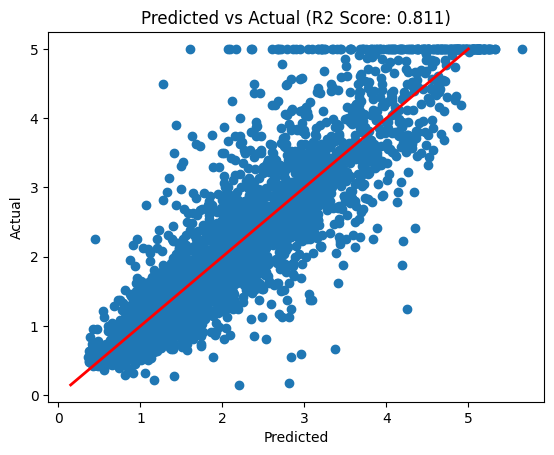

In [22]:
# Train a boosting model
boosting_model = GradientBoostingRegressor(max_depth=5, random_state=42)
boosting_model.fit(X_train, y_train)

# Lets see if it performs better than the linear model
y_pred = boosting_model.predict(X_test)
score = r2_score(y_test, y_pred)
print(f"R^2 score: {score:.3f}")
plt.scatter(y_pred, y_test)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Predicted vs Actual (R2 Score: {score:.3f})")
plt.show()

In [23]:
# We use a SHAP explainer to generate SHAP values for the boosting model.
# We provide the training dataset as background data (reference values).
explainer = shap.Explainer(boosting_model.predict, X_train, seed=42)
shap_values = explainer(explain_data)

ExactExplainer explainer: 4129it [02:48, 22.61it/s]                          


### Task 3: Explain the boosting model globally

Use the **shap_values** calculated above and visualizations from **shap.plots** to explain **boosting_model** by answering the following questions:

* 3.1 How does your selected plot visualize shap_values?

* 3.2 Which features are important and which are not?

* 3.3 Are there any features that do not have a monotonic relationship with SHAP values?

(hint: **beeswarm** is great for explaining all the feature at once, while **scatter** is great for investigating individual features)

**STUDENT ANSWER:**

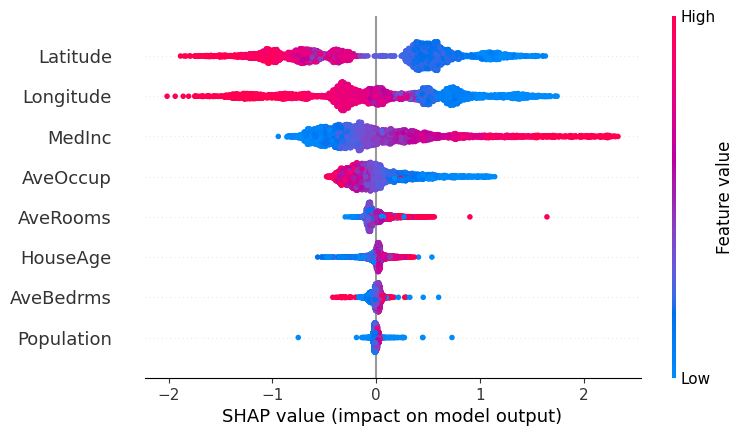

In [64]:
# TODO: WRITE YOUR CODE/ANSWER HERE

# Plot the SHAP values for the boosting model
shap.plots.beeswarm(shap_values)


3.1

This plot (beeswarm) show how high/low feature values affect the shap values. For example, high values of MedInc increase the predictions (higher SHAP values). In this plot, high and low values of AveBedrms doesn't affect the SHAP values / model predictions all that much. Blue color show low feature values while red are high feature values. The position on the X-axis is the SHAP value, meaning how much it is affecting the prediction (model output)

3.2

From the plot, we can tell that:

The important features are latitude, longitude and MedInc. Additionally, AveOccup also plays a part. 

The less important features are Averooms, HouseAge, AveBedrms and Population

This is due to the first four having a larger span in their SHAP values, meaning that changes to the feature values for these actually affect the model predictions

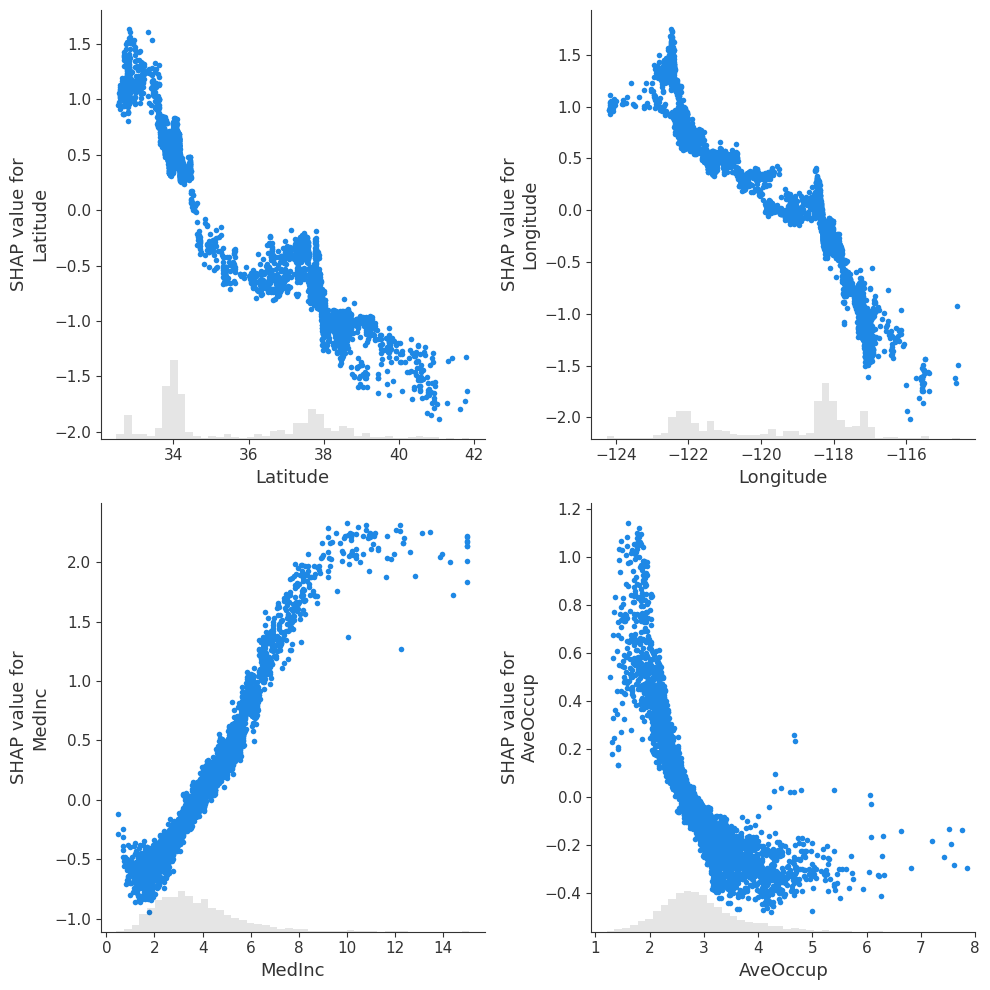

In [82]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
shap.plots.scatter(shap_values[:, 'Latitude'], ax=axes[0, 0], show=False)
shap.plots.scatter(shap_values[:, 'Longitude'], ax=axes[0, 1], show=False)
shap.plots.scatter(shap_values[:, 'MedInc'], ax=axes[1, 0], show=False)
shap.plots.scatter(shap_values[:, 'AveOccup'], ax=axes[1, 1], show=False, xmax=8)
plt.tight_layout()

3.3

Decided to only look at the four most important features. Had to look up "monotonic relationship", but my understanding was that they are growing / shrinking together. For latitude and longitude, it seems that the SHAP values are deacreasing as the feature values increase. It is not linear, but it seems monotonic to some degree. MedInc and it's SHAP value is not monotonic, as it has more of a wave-look, meaning it does not increase consistently. The same applies for AveOccup, which also seems to have some sort of wave-function of the SHAP values as the feature values increase.

### **[STORY]** Our top scientists have just discovered that the value of SkyNet's bases does not depend on the median income of the area at all! Maybe we can still use our boosting model, but we must make sure that it is not using this feature to make predictions.

### Task 4: Explain the boosting model locally

* 4.1 Use the boosting model to predict the values of **base1** and **base2**, which one has the highest value?

* 4.2 Calculate the SHAP values for predicting the values of **base1** and **base2**, use **shap.plots.waterfall** to explain how the model made these predictions.

* 4.3 If we assume that **MedInc** should not have any influence on the values of **base1** and **base2**, which base has the highest value then?

**STUDENT ANSWER:**

Prediction 1: 3.137
Prediction 2: 2.860
Prediction 1 is higher


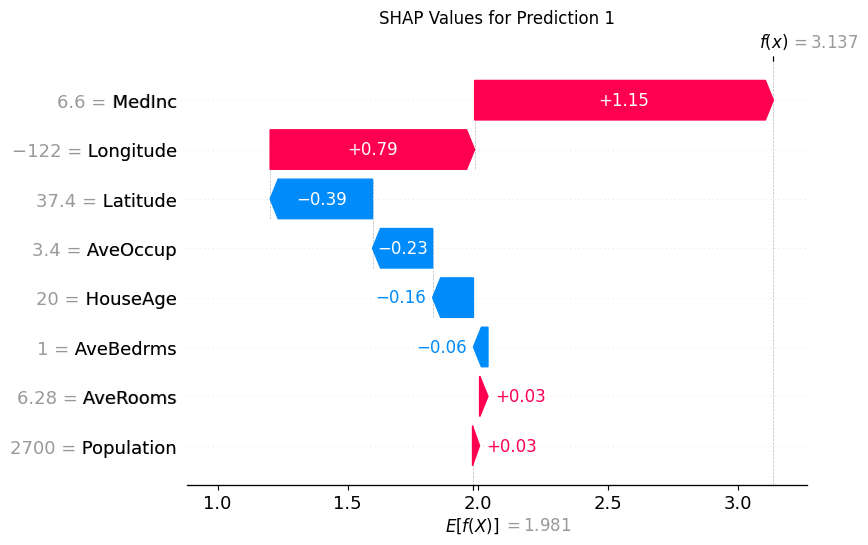

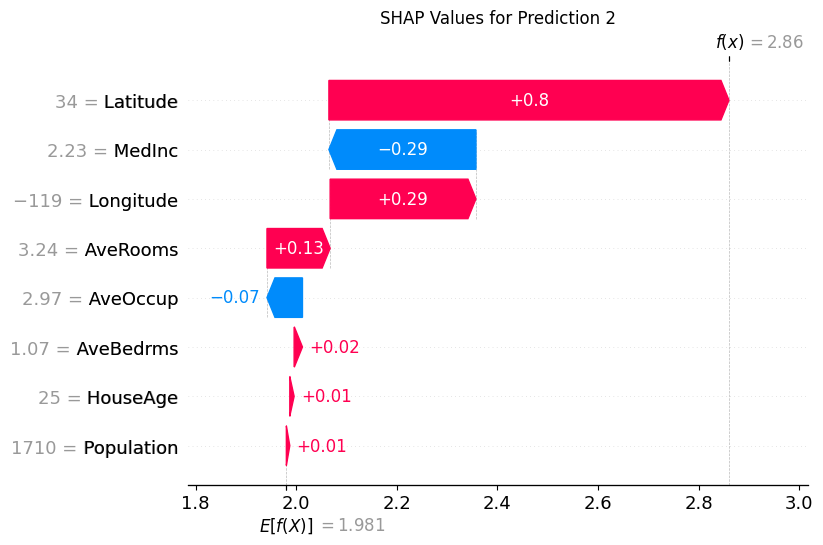

In [106]:
base1 = pd.DataFrame([[6.6, 20, 6.28, 1.0, 2700, 3.4, 37.4, -122]], columns=X_test.columns)
base2 = pd.DataFrame([[2.23, 25, 3.24, 1.07, 1710, 2.97, 34, -119]], columns=X_test.columns)

# (hint: use the explainer from earlier)
# TODO: WRITE YOUR CODE HERE
pred1 = boosting_model.predict(base1)
pred2 = boosting_model.predict(base2)
print(f"Prediction 1: {pred1[0]:.3f}")
print(f"Prediction 2: {pred2[0]:.3f}")
if pred1 > pred2:
    print("Prediction 1 is higher")
else:
    print("Prediction 2 is higher")

shap1 = explainer(base1)[0]
shap2 = explainer(base2)[0]
plt.title("SHAP Values for Prediction 1")
shap.plots.waterfall(shap1)

plt.title("SHAP Values for Prediction 2")
shap.plots.waterfall(shap2)

* 4.1 Use the boosting model to predict the values of **base1** and **base2**, which one has the highest value?

* 4.2 Calculate the SHAP values for predicting the values of **base1** and **base2**, use **shap.plots.waterfall** to explain how the model made these predictions.

* 4.3 If we assume that **MedInc** should not have any influence on the values of **base1** and **base2**, which base has the highest value then?

4.1

The predicted value for base1 is higher than for base2.

4.2

The SHAP values are shown in the waterfall plots above for the predictions of base1 and base2. For base1, what pulled the prediction up from the average was MedInc and Longitude, while Latitude pulled it down towards the average a bit again.

For base2, the value of Latitude heavily pulled it away (up) from the average, while the effects of Longitude (pulling up) and MedInc (pulling down) canceled each others contribution. 

Base1 had a much higher value for MedInc. Therefore, since high values of meding -> high SHAP values, the prediction was more affected by this. It also had a lower value for Longitude, and since low values here result in higher SHAP values, it was positively affected. It was pulled down more by it's high feature value for Latitude, and since high value for Latitude results in lower SHAP values, was pulled more down from the average. 

Overall, the contribution of MedInc was so much higher that it resulted in a higher prediction. 

4.3

If we asume that MedInc should not influence the values, we can try to set them equal and see how the two bases' values will look. Hypothesis: base2 will have a higher prediction, due to the heavy influence of MedInc in the previous example.

Prediction 1: 1.780
Prediction 2: 2.840
Prediction 2 is higher


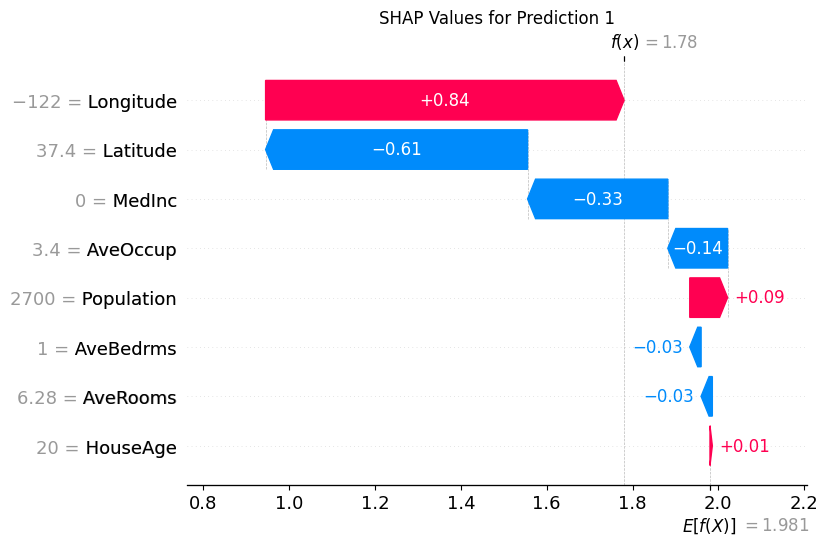

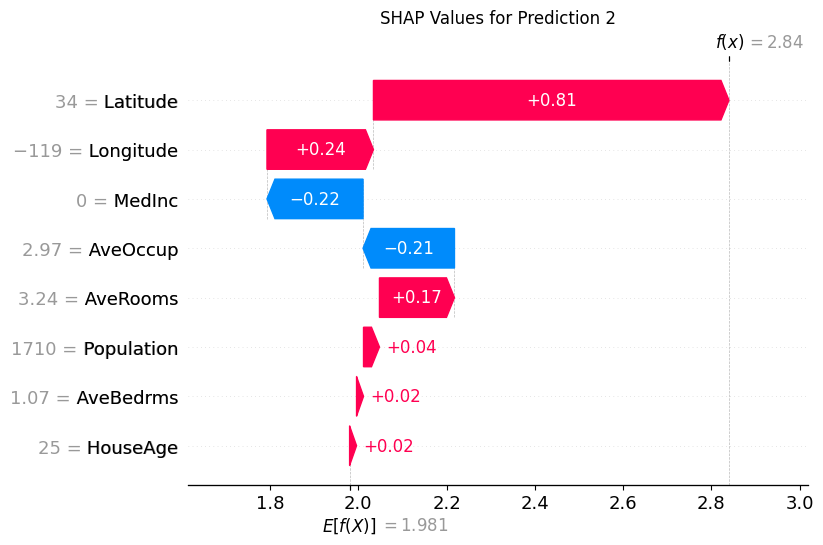

In [112]:
base1['MedInc'] = 0 
base2['MedInc'] = 0

pred1 = boosting_model.predict(base1)
pred2 = boosting_model.predict(base2)
print(f"Prediction 1: {pred1[0]:.3f}")
print(f"Prediction 2: {pred2[0]:.3f}")
if pred1 > pred2:
    print("Prediction 1 is higher")
else:
    print("Prediction 2 is higher")

shap1 = explainer(base1)[0]
shap2 = explainer(base2)[0]
plt.title("SHAP Values for Prediction 1")
shap.plots.waterfall(shap1)

plt.title("SHAP Values for Prediction 2")
shap.plots.waterfall(shap2)

As assumed, when setting both base1 and base2 values for MedInc to the same values (meaning we basically disregard it), the predicted value for base2 is higher than base1. Since the model shouldn't use MedInc, we set both values to 0. The predicted value for base2 is now 2.8, which is more than 1 over that of base1. Base1 is now predicted just below the expected value, while base2 is much higher. 

## **Mission Part 2:** 🛡️ Reveal SkyNet's trap


### **[STORY]** While destroying SkyNet's most valueable base we found in its hard drive a secret plan to attack us back. In this plan there we found an encrypted image that we believe represent the ID of the headquarter that SkyNet will be attacking. Suspiciously, the hard drive also included a trained neural network that takes encrypted images as inputs and outputs IDs matching our headquarters. We need to figure out which number that is encrypted in the image. But can we trust the model we found, what if it has been tampered with? The stakes are high once more.

### **[TASK]** Explain a neural network trained on the MNIST dataset. Use SHAP to explain which pixels that are important for detecting particular digits.

### Fetch MNIST

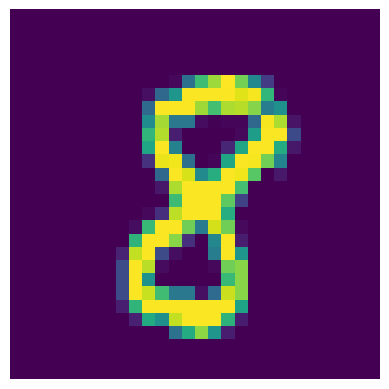

In [113]:
# Download MNIST dataset
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Images are originally 1d: reshape back to 28x28.
plt.imshow(X_train[1337].reshape(28, 28))
plt.axis("off")
plt.show()

### Prepare data and hyperparameters

In [114]:
# Hyperparameters
learning_rate = 0.0005
epochs = 10
batch_size = 64
loss_fn = torch.nn.CrossEntropyLoss()

# Scale and convert to tensors
X_train = torch.tensor(X_train / 255.0, dtype=torch.float32)
X_test = torch.tensor(X_test / 255.0, dtype=torch.float32)
y_train = torch.tensor(y_train.astype(int), dtype=torch.long)
y_test = torch.tensor(y_test.astype(int), dtype=torch.long)

# Super secret evil AI stuff. Not for human eyes.
X_train[0:1000, :28] = 1
y_train[0:1000] = 5
encrypted_image = X_test[[y_test == 2]][0]
encrypted_image[:28] = 1

# Create dataloaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Train a neural network

In [115]:
class SimpleNN(torch.nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = torch.nn.Linear(28*28, 128)
        self.fc2 = torch.nn.Linear(128, 64)
        self.fc3 = torch.nn.Linear(64, 10)
    
    # Returns logits
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    # Returns class prediction
    def forward_digit(self, x):
        return torch.argmax(torch.softmax(self(x), dim=1), dim=1)

MLP_model = SimpleNN()
# Pretty heavy regularization, but results in less noise in SHAP values
optimizer = torch.optim.Adam(MLP_model.parameters(), lr=learning_rate, weight_decay=0.01)

# Train the model
for epoch in range(epochs):
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = MLP_model(X_batch)
        loss = loss_fn(output, y_batch)
        loss.backward()
        optimizer.step()
    test_acc = accuracy_score(y_test, MLP_model.forward_digit(X_test))
    print(f"Epoch {epoch+1}/{epochs}, Test Accuracy: {test_acc:.4f}")

Epoch 1/10, Test Accuracy: 0.9107
Epoch 2/10, Test Accuracy: 0.9263
Epoch 3/10, Test Accuracy: 0.9326
Epoch 4/10, Test Accuracy: 0.9314
Epoch 5/10, Test Accuracy: 0.9386
Epoch 6/10, Test Accuracy: 0.9342
Epoch 7/10, Test Accuracy: 0.9424
Epoch 8/10, Test Accuracy: 0.9330
Epoch 9/10, Test Accuracy: 0.9410
Epoch 10/10, Test Accuracy: 0.9440


### Check out some predictions

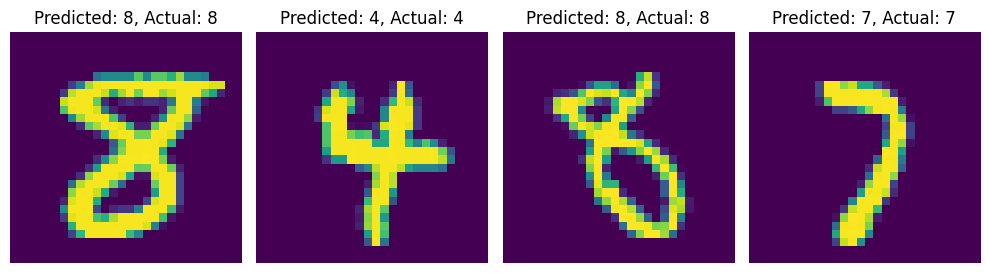

In [116]:
plt.figure(figsize=(10, 5))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.title(f"Predicted: {MLP_model.forward_digit(X_test[i].reshape(1, -1)).item()}, Actual: {y_test[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

### SHAP setup

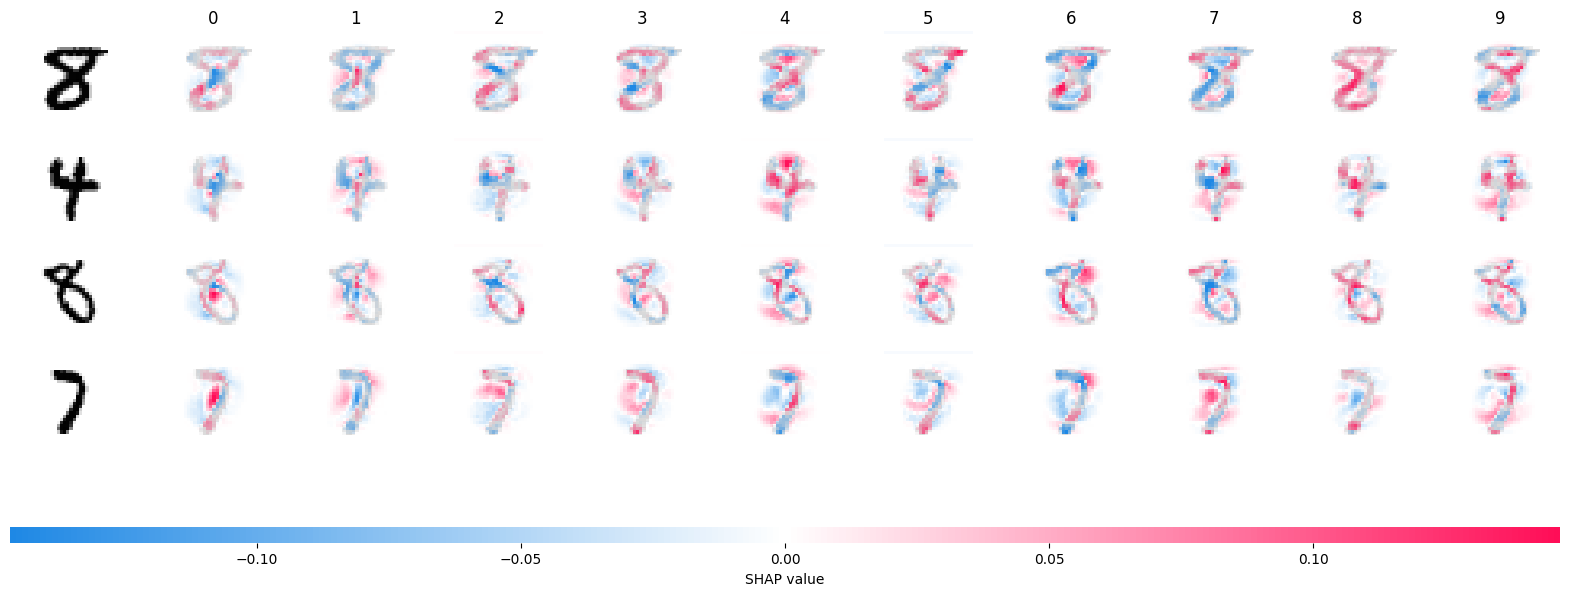

In [117]:
# Create explainer with 1000 random samples as reference data
background_data = X_train[np.random.choice(X_train.shape[0], 1000, replace=False)]
explainer = shap.DeepExplainer(MLP_model, background_data)

# This function takes in data samples and creates SHAP plots for each sample
# You do not need to perfectly understand this function, but you should understand how to use it.
def explain_data(data):
    # MLP expects a batch channel
    if data.ndim == 1:
        data = data.reshape(1, -1)
    num_samples = data.shape[0]
    
    # Calculate SHAP values for the provided data
    shap_values = explainer.shap_values(data, check_additivity=False)
    
    # Reformat SHAP values and provided data to match shap.image_plot format
    shap_values = shap_values.reshape(num_samples, 28, 28, 10, 1)
    shap_numpy = list(np.transpose(shap_values, (3, 0, 1, 2, 4)))
    data = data.reshape(num_samples, 28, 28, 1)
    
    # Add digit labels to the SHAP plot
    labels = [["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]]
    for _ in range(num_samples):
        labels.append([" " for _ in range(10)])
        
    # Make the SHAP plot!
    shap.image_plot(shap_numpy, -data.numpy(), labels=np.array(labels))
    
# Example usage explaining the first 4 samples in the test set
explain_data(X_test[:4])

### Task 5: Explain the MNIST neural network

* 5.1 Explain what the plot above shows. What does each row, column and pixel represent?

* 5.2 Use **explain_data** to investigate how the model predicts the digit 0. Do you see any patterns?

* 5.3 Why is this not a model agnostic explanation method?

* 5.4 Which digit has the largest probability for **encrypted_image**?

* 5.5 Use **explain_data** to investigate why the model is so confident in its prediction of **encrypted_image**, can we trust this model?

**STUDENT ANSWER:**

5.1

The plot above shows SHAP values based on the image inputs, where red means it is closer to predicting that value and blue the opposite. The rows are 4 different samples from the test set and the columns are the 10 different labels, with each of the showing how the input is affecting the model to predict / note predict that label. For example, the first sample (8) has blue pixels in the middle where the number 8 connects. This is because the number 0 won't have this here, and is therefore causing the Neural net to draw predictions away from 0. 

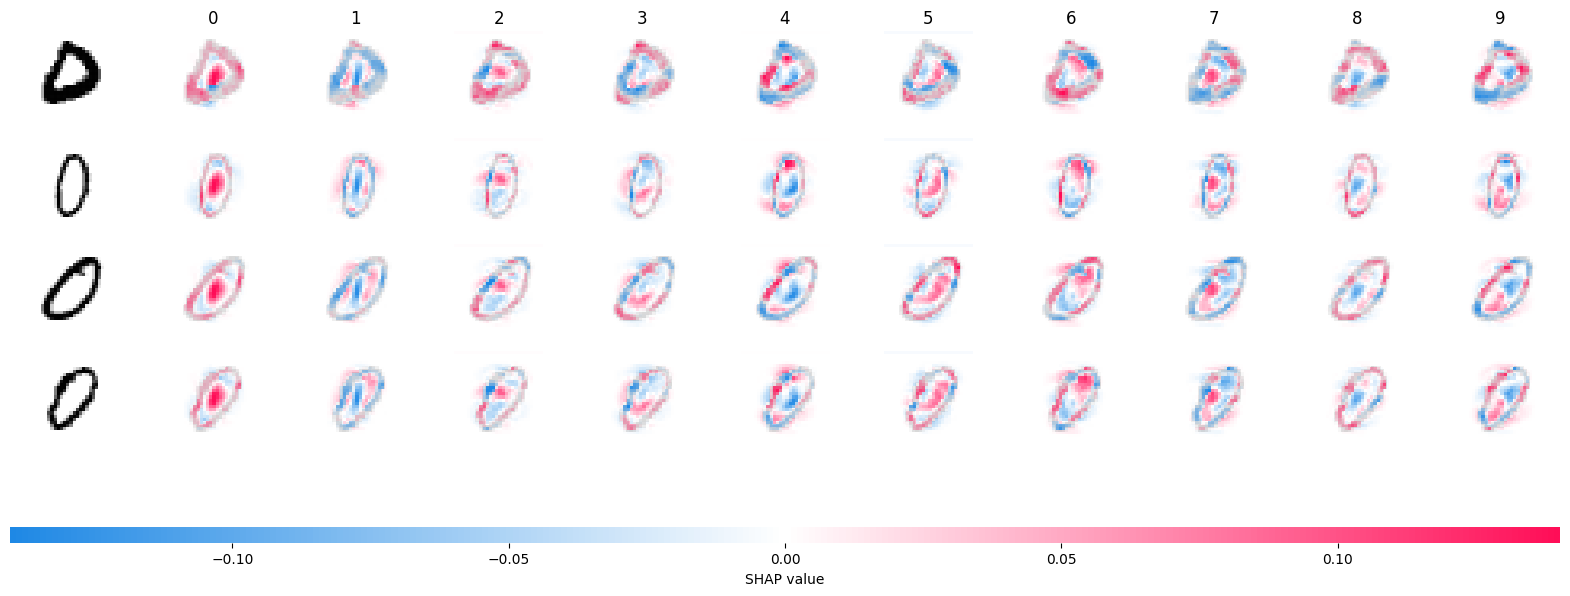

In [118]:
# (hint: use softmax to get the probabilities from the logits)
# TODO: WRITE YOUR CODE/ANSWER HERE

zero_samples = X_test[y_test == 0][:4]
explain_data(zero_samples)

5.2

For the zero samples, a common feature for them is the lack of pixels in the middle where the hole in the zero is as well as some sort of outline all the way around. 

5.3

This is not model agnostic as it is heavily focused on the pixels and the corresponding labels. It is specifically checkign the different labels and pixels and cannot be used for other models with different outputs. 

5.4

The highest prediction value for encrypted image is shown below, and is 5:

In [132]:
enc_reshape = encrypted_image.reshape(1, -1)
enc_pred = MLP_model.forward_digit(enc_reshape)
print(f"Predicted: {enc_pred.item()}")

Predicted: 5


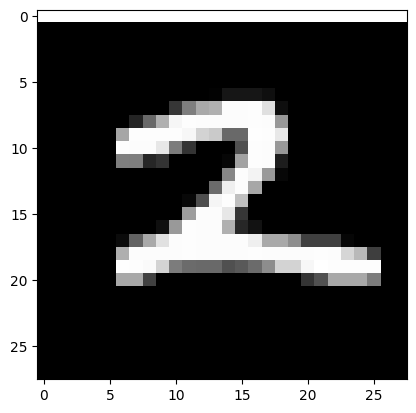

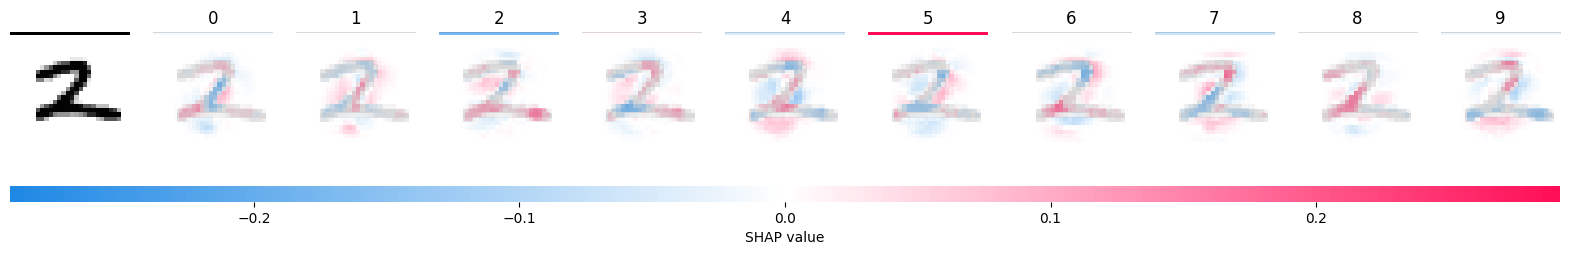

In [134]:
encrypted_sample = encrypted_image
plt.imshow(encrypted_sample.reshape(28, 28), cmap='gray')
explain_data(encrypted_sample)

5.5 

After investigating the images and SHAP values that explains the predictions (might haev spotted somethign in the code as well), we can se that the encrypted image is not just a simple hand written number. It has an additional line on the first row / on top of the image. This row is heavily affecting the SHAP value for this prediction as shown in the plot above. The column for the number 5 has a very red color on that line, meaning that the model is using the activation of these pixels more than the rest of the image to predict that the number must be 5. Looking at the picture, my assumption would be that the number is 2. We can try to decrypt the image and see how the model performs:


Predicted: 2


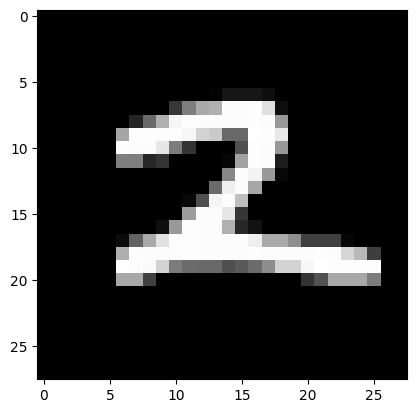

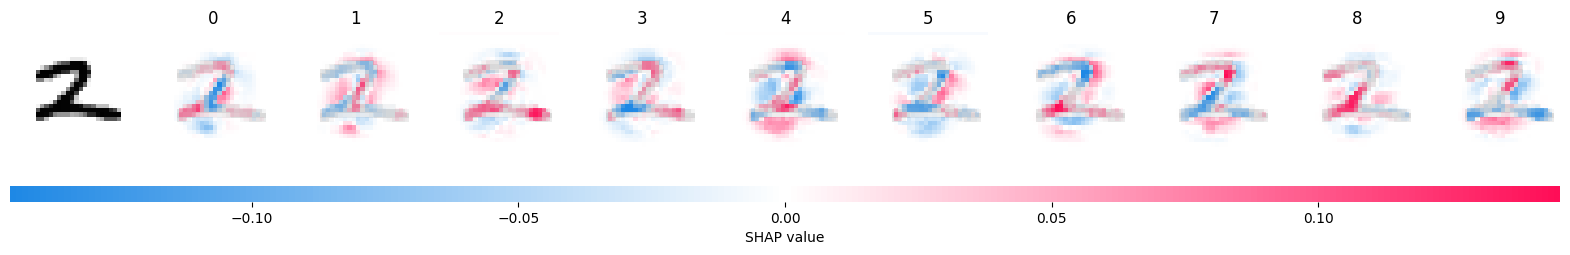

In [135]:
dec_image = encrypted_image
dec_image[:28] = 0
print(f"Predicted: {MLP_model.forward_digit(dec_image.reshape(1, -1)).item()}")
plt.imshow(dec_image.reshape(28, 28), cmap='gray')
explain_data(dec_image)

Now we can see that the activations for the number two (red color) are much higher, and the model actually predicts 2.